<h1 style='color:#3469e5'><b> Libs usadas nesse projeto <i></i>:</b></h1>

In [2]:
import requests, zipfile, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas_profiling import ProfileReport


<h1 style='color:#3469e5'><b> Abrindo o dataset <i></i>:</b></h1>


Escolhi essa abordagem para abrir o dataset, pois não fazer o download do arquivo estava me custando mais processamento do que tenho disponivel.

In [4]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'
r = requests.get(url, stream=True,verify=False)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

C:\Users\Carol\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [5]:
z.namelist()

['bank-full.csv', 'bank-names.txt', 'bank.csv']

In [6]:
df = pd.read_csv('bank-full.csv', sep=';')

In [10]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [8]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


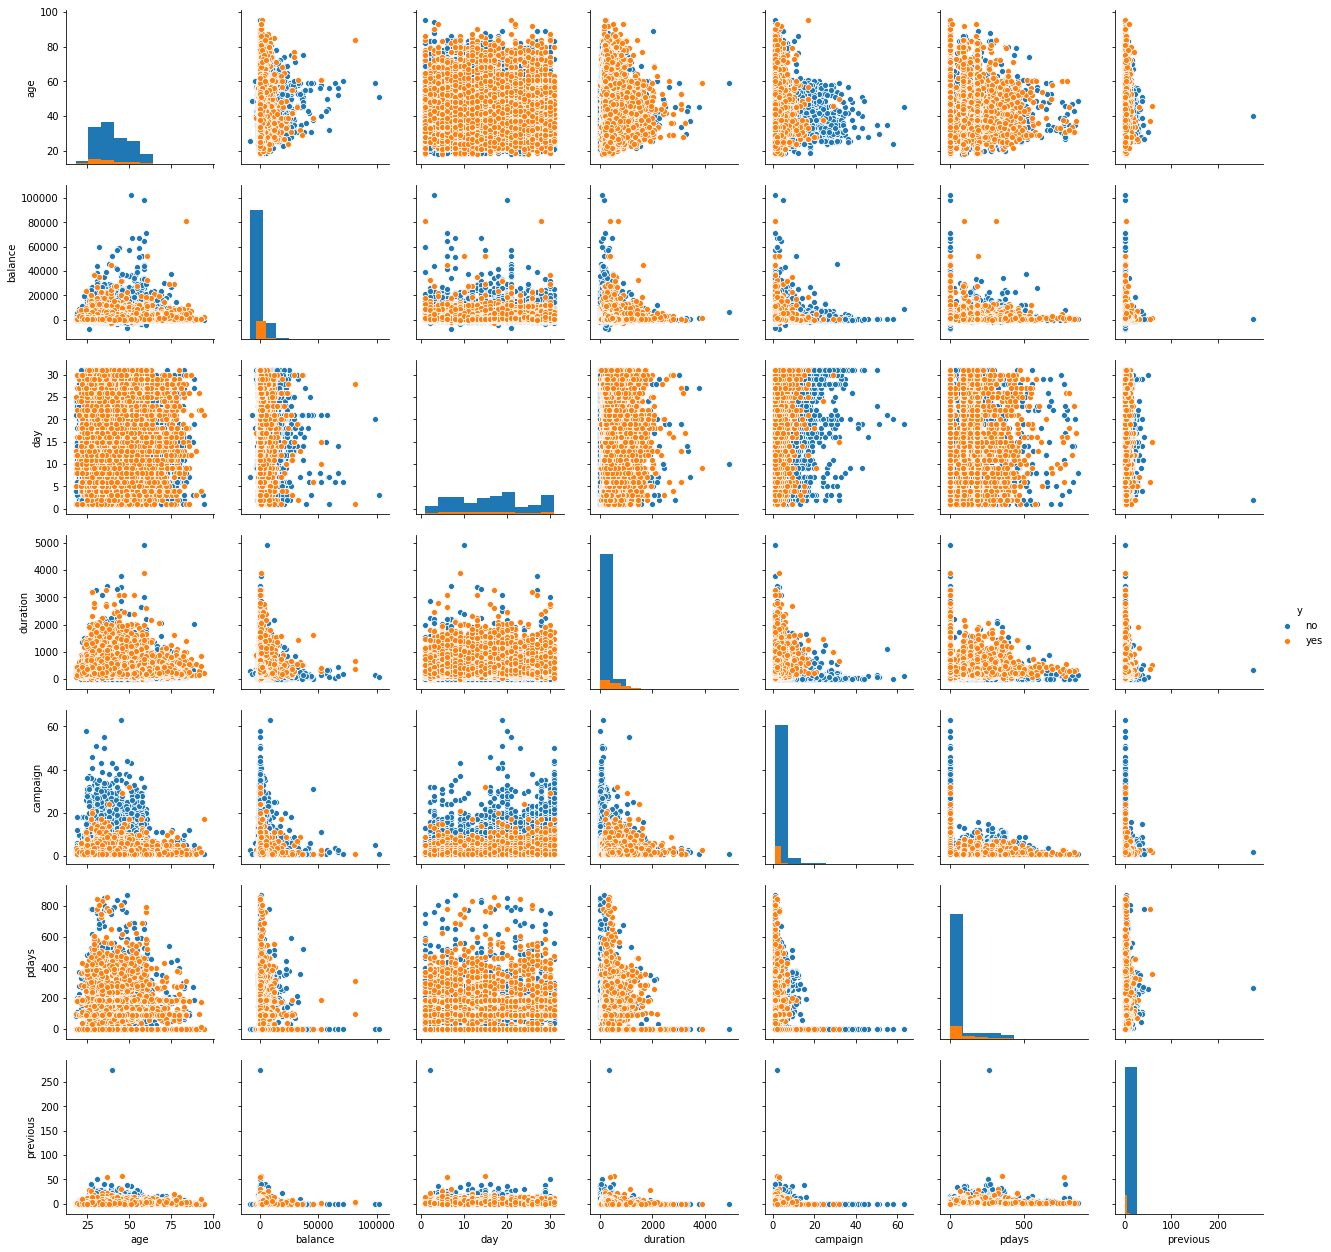

In [9]:
sns.pairplot(df,
            hue='y',
            diag_kind='hist')

In [10]:
profile = ProfileReport(df)
profile

Number of variables,17
Number of observations,45211
Total Missing (%),0.0%
Total size in memory,5.9 MiB
Average record size in memory,136.0 B
Numeric,7
Categorical,10
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [11]:
# transformando algumas dimenções em binário para facilitar análise.
df.replace('yes', 1, inplace=True)
df.replace('no', 0, inplace=True)

<h1 style='color:#3469e5'><b> 1. Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?  <i></i></b></h1>


Olhando o gráfico podemos observar que neste dataset os blue-collar pega 26,9% mais empréstimos que o restante das profissões e 80,7% desses empréstimos é imobiliario. Optei em fazer essa análise pois com as variáveis que compõem esse dataset não tive tempo hábil de analisar de forma preditiva qual profissão pedirá um empréstimo e em quanto tempo.

In [12]:
pivot = df.pivot_table(index=["job"], values = ['loan', 'housing'], aggfunc=np.sum).sort_values(by=['loan','housing'],ascending=False)

In [13]:
T = pivot['loan'].sum() + pivot['housing'].sum()

In [14]:
(pivot['loan'][0] + pivot['housing'][0]) / T *100 #% de blue-collar

26.97226169148082

In [16]:
pivot['housing'][0] / (pivot['loan'][0] + pivot['housing'][0]) *100 #% de emprestimo imobiliário para blue-collar

80.71461291800274

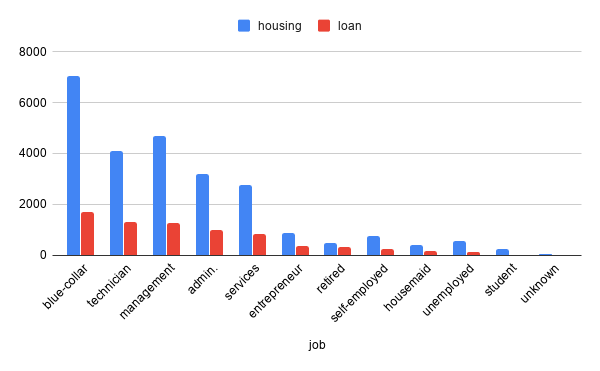

In [17]:
from IPython.display import Image
Image(filename='chart.png') 

<h1 style='color:#3469e5'><b> 2. Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados?   <i></i></b></h1>


O ponto que mais me chamou a atenção foi o numero de ligações necessárias para realizar uma venda. 23.6 ligações é um número muito alto, há a necessidade de otimizar esse processo por que o grande número de ligações não está correlacionado a chance de sucesso.

In [18]:
#transformando as variáveis categóricas em binárias
df_dummies = pd.get_dummies(df, dtype=str)

In [19]:
# Limpezinha
df_dummies.rename(columns={'job_admin.' : 'job_admin'}, inplace=True)
df_dummies.replace('' , 0 , inplace=True)
df_dummies = df_dummies.astype(int)

In [20]:
def plot_corr(corr):
    # Cortei a metade de cima pois é o espelho da metade de baixo
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask, 1)] = True
    f, ax = plt.subplots(figsize=(45, 15))
    sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9),
            square=True, ax=ax)

In [21]:
df_dummies['y'].corr(df_dummies['campaign']) #correlação fortemente negativa

-0.07317200634586693

In [22]:
df_dummies['campaign'].sum() / df_dummies['y'].sum() #numero de ligações para 1 venda

23.625638116846286

In [23]:
why = df_dummies.loc[df_dummies['y'] == 1]

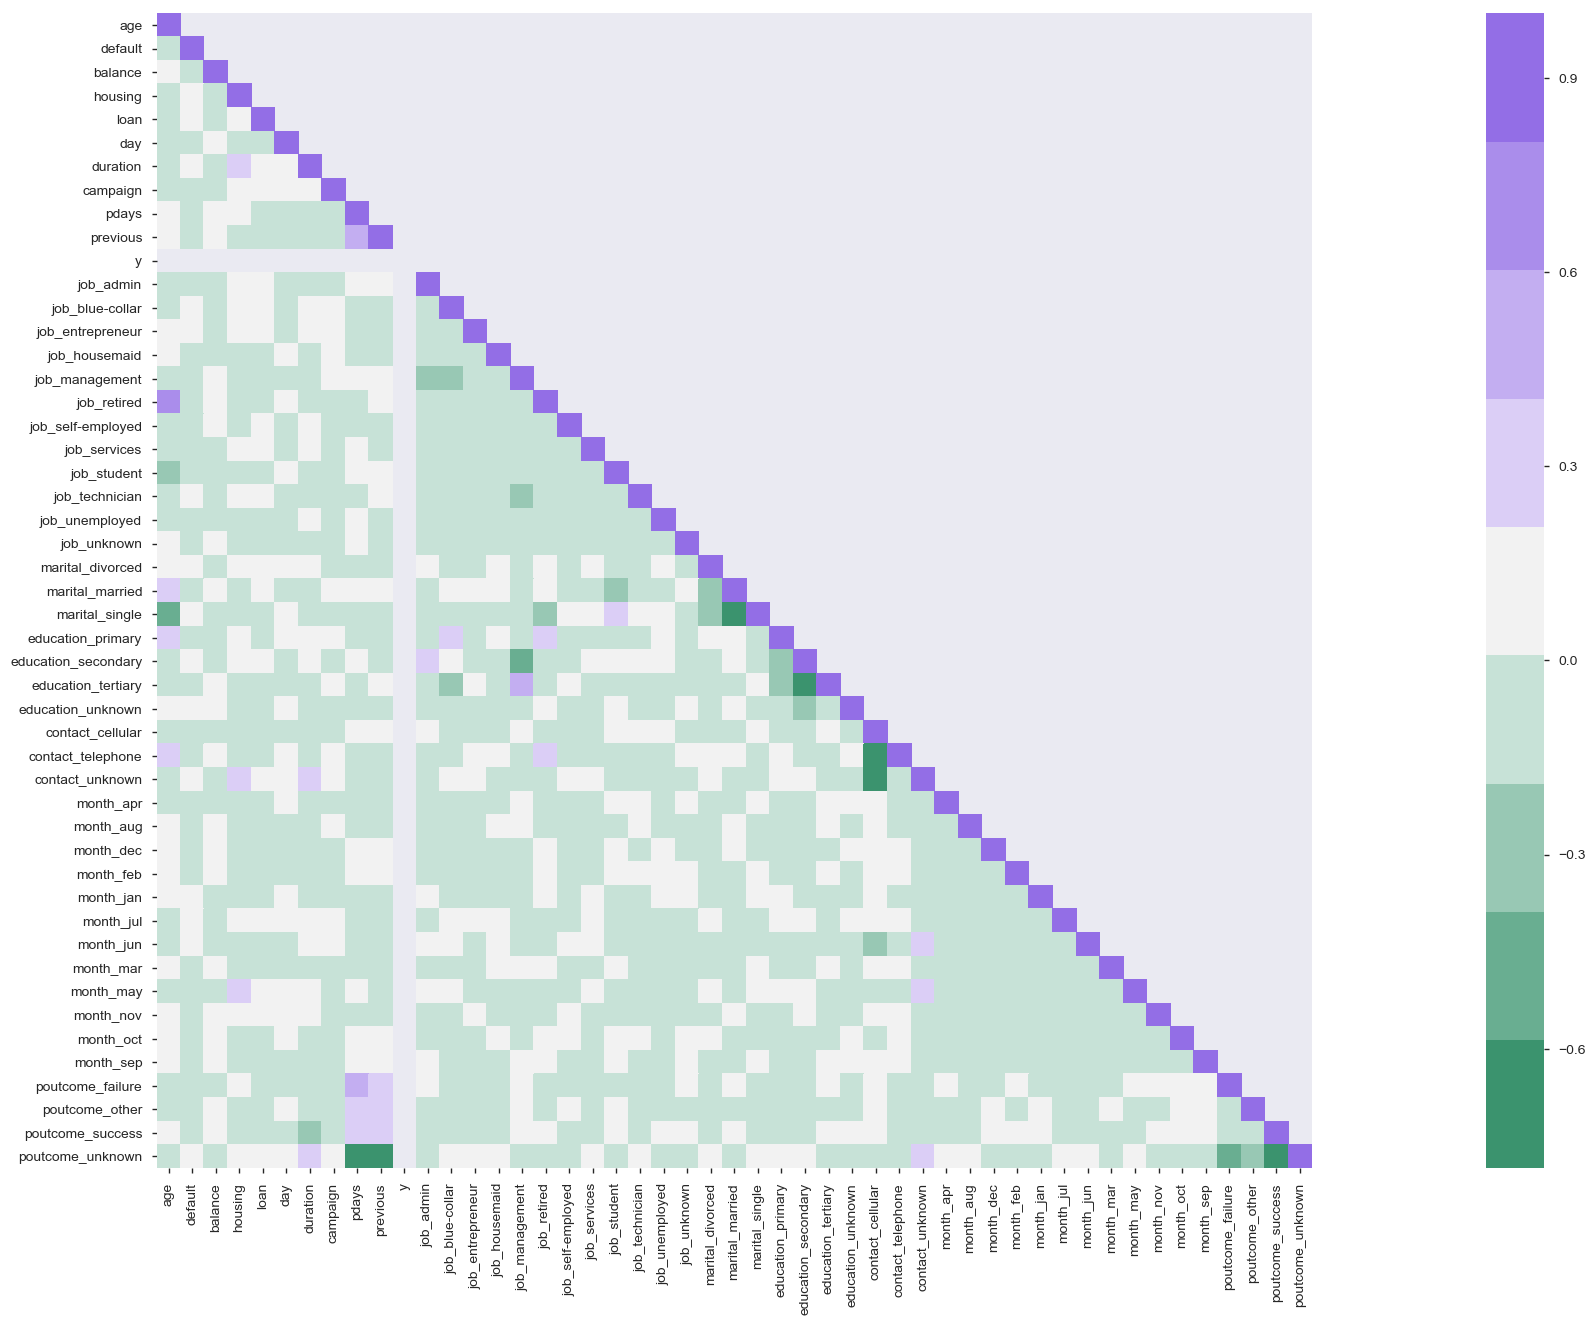

In [24]:
plot_corr(why.corr()) # Correlação do sucesso